In [1]:
# !python -m pip install stellargraph chardet networkx seaborn numpy pandas tqdm gensim scikit-learn

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from functools import reduce
import datetime
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from utils import * 
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter, BiasedRandomWalk, TemporalRandomWalk
from scipy.special import softmax
from tqdm import tqdm
import math
from sklearn.preprocessing import normalize
from math import isclose
from sklearn.decomposition import PCA
import multiprocessing
import sklearn.model_selection 
from gensim.models import Word2Vec

2024-04-29 15:38:37.716369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# CM_Time() & Weekly Graph Construction

In [3]:
class temporalNetwork(): 
    def __init__(self, start_date, end_date, display_progress=False, location_grouping='kma', origin=None, facility_id=None, intermediate=None):
        """ 
        Note: 
            start_date and end_date should be both None as they are used as a signal to 
            CM_Time's run_simulation to whether construct a new graph or update the graph with new information 
        """
        self.display_progress = display_progress
        self.start_date=start_date
        self.end_date=end_date
        self.network=None
        self.origin_location_list=None
        self.location_grouping=location_grouping
        self.inbound_data = None 
        self.outbound_data = None

    def construct_network_graph(self):
        """ 
        Given an inbound and outbound dataframe, construct a network graph and stores it in the class variable self.network
        Args: 
            an_inbound_df (pd.DataFrame): inbound dataframe
            an_outbound_df (pd.DataFrame): outbound dataframe
            start_date (datetime): start date of the network graph
            end_date (datetime): end date of the network graph
            location_grouping(string): 'kma' or 'zip3'
        """
        # pull data & construct an empty multiDiGraph

        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        an_inbound_df, an_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        an_inbound_df.load_date, an_outbound_df.load_date = pd.to_datetime(an_inbound_df.load_date), pd.to_datetime(an_outbound_df.load_date)
        for colin, colout in zip(an_inbound_df.columns, an_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                an_inbound_df[colin] = an_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                an_outbound_df[colout] = an_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, an_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, an_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, an_inbound_df, an_outbound_df, self.location_grouping)
        
        # update the variables 
        self.network = network_graph
        self.origin_location_list = an_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = an_inbound_df, an_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
        
    def move_to_next_week(self): 
        """ 
        Given the new week's inbound and outbound dataframes, 
        update self.network graph, self.start_date, and self.end_date to a week after current start date and end date 
        
        Args:
            next_inbound_df (pd.DataFrame): new week's inbound dataframe
            next_outbound_df (pd.DataFrame): new week's outbound dataframe
            display_progress (boolean): whether to display the progress of the function or not
        """
        # update the dates, pull new week's data, & store some informations
        self.start_date, self.end_date = self.start_date + timedelta(days=7), self.end_date + timedelta(days=7)
        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        next_inbound_df, next_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        next_inbound_df.load_date, next_outbound_df.load_date = pd.to_datetime(next_inbound_df.load_date), pd.to_datetime(next_outbound_df.load_date)
        for colin, colout in zip(next_inbound_df.columns, next_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                next_inbound_df[colin] = next_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                next_outbound_df[colout] = next_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"new network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, next_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, next_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, next_inbound_df, next_outbound_df, self.location_grouping)

         # update the variables 
        self.network = network_graph
        self.origin_location_list = next_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = next_inbound_df, next_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
       

    def print_network_information(self, given_network, print_network_time=False): 
        """
        Given a network, print out the information of the network
        Args: 
            given_network (nx.MultiDiGraph): a network graph
        Returns: N/A
        """
        print("---------------------------------------------------------------------------------------------") 
        print(given_network)
        print(f"Is the given network a DAG for load_network?: {nx.is_directed_acyclic_graph(given_network)}")
        print(f"Number of self loops: {nx.number_of_selfloops(given_network)}")
        if print_network_time: print(f"Current time of the graph: {given_network.graph['start_date']} to {given_network.graph['end_date']}")
        else: print(f"Current time of the graph: {self.start_date} to {self.end_date}")


In [4]:
class CM_Finder():
    def __init__(self, location_grouping='kma', origin_location_list=None, network = None):
        self.network=network
        self.processed_network=None
        self.processed=False 
        self.origin_location_list=origin_location_list
        self.match_failure = None
        self.remove_failure = 0
        self.location_grouping=location_grouping
        
    def group_to_DiGraph(self, display_progress = False):
        """
        #TODO: explain why aggregate_faciility_zip then group_to_DiGraph (kma-> facility_zip -> kma to kma->kma->kma, aggregate to faciliy KMA)
        Assuming that self.network is constructed, 
        sums the edge weights for edges with the same nodes in self.network variable and 
        stores the new graph with aggregated edges in self.processed_network variable and returns False if successful 

        Args:
            display_progress (boolean): whether to display the progress of the function or not

        NOTE) disregards temporal factor 
        """
        if not self.network: 
            print("Please construct the network first")
            return None 
            
        new_name = self.network.name + " reduced"
        self.processed_network = nx.DiGraph(name=new_name)
        self.processed_network.add_nodes_from(self.network)

        if display_progress: print("Aggregating nodes by KMA...")
        for n1, n2 in self.network.edges():
            sum = 0 
            for inner_dict in self.network.get_edge_data(n1, n2).values(): 
                sum += inner_dict['capacity']
            self.processed_network.add_edge(n1, n2, capacity = sum)
        
        nx.set_edge_attributes(self.processed_network, to_integer(self.network.graph['end_date']), 'time')
        self.processed = True

In [5]:
class CM_Time(): 
    def __init__(self, location_grouping='kma', origin=None, facility_id=None, intermediate=None): 
        self.start_date=None
        self.end_date=None
        self.cm_network = None   
        self.cm_finder = None
        self.origin=origin
        self.facility_id=facility_id
        self.intermediate=intermediate
        self.location_grouping = location_grouping
        self.weekly_graphs = {}
    
    def update_dates(self): 
        """
        Updates the start and end date by 7 days
        """ 
        self.start_date += timedelta(days=7)
        self.end_date += timedelta(days=7)

    def construct_or_update_tg(self, filter_key='load_count', display_progress=False, display_path_info=False):
        """ 
        Either (1) creates a network graph given a start and end date 
            or (2) updates the network graph to the next week's graph 

        Args: 
            start_date, end_date: start & end date of the first two weeks of the simulation

        Returns: n/a
        """        
        # construct or update cm_finder.network 
        if not self.cm_network: 
            self.cm_network = temporalNetwork(self.start_date, self.end_date, display_progress, self.location_grouping, self.origin, self.facility_id, self.intermediate)
            self.cm_network.construct_network_graph()
            self.cm_finder = CM_Finder(location_grouping=self.location_grouping)
        else: 
            self.cm_network.move_to_next_week()

        self.cm_finder.origin_location_list = self.cm_network.origin_location_list
        self.cm_finder.network = self.cm_network.network
        
        # self.cm_finder.group_to_DiGraph(display_progress = display_progress)
        self.weekly_graphs[self.end_date] = self.cm_finder.network

    def temporal_query(self, start_date, temporal=True, looback = 7, number_of_weeks=None, termination_date = None, \
                    filter_key = "load_count", display_progress=False, display_path_info = False): 
        """
        Given a start date, run the simulation for number_of_weeks or until termination_date is reached.

        Args: 
            start_date: start date of the first week of the simulation
            temporal: if True, run the simulation for every two weeks, if False, run the simulation from start_date until end_date
            number_of_weeks: number of weeks to run the simulation for
            termination_date: date to stop the simulation
            filter_key: key to filter the network on (load_count or path_score)
            display_progress: if True, display progress bar
            display_path_info: if True, display path info

        Returns: a dictionary of simulation result for each week
            
        Note:
        * termination_date: termination date of the entire analysis, when end_date reaches termination_date, the query loop terminates,
        * end_date: the end date of the two-week window, will be updated every week

        - Once the parameters (location_grouping, origin, facility_id, intermediate) are used to initialise the cm_time class, 
          they will be used for any further analysis until new initialisation happens.
          query_weekly method will only perform analysis, no alterations can be made by calling solely this.

        - If temporal=True, --> end_date != termination_date, eventually at the end of simulations, end_date = termination_date
            and number_of_weeks is given, end_date = start_date + 13 days for the first simulation, termination_date = start_date + 7 days * number_of_weeks
            and termination_date is given, end_date = start_date + 13 days for the first simulation and termination_date=termination_date for the simulation
          If temporal=False --> end_date = termination_date 
            and number_of_weeks is given, end_date = start_date + 7 days * number_of_weeks for the simulation 
            and termination_date is given, end_date=termination_date for the simulation

        * simulation_results: a dictionary with key as the end_date and value as the simulation result
        """

        # create information needed for a new query with the given start_date and number_of_weeks
        # possible bug when end_date > termination_date.
        if temporal: 
            self.start_date, self.end_date = start_date, start_date + timedelta(days=looback-1)

            if number_of_weeks: termination_date = self.start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: termination_date = termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
        
            # run simulation for every two weeks until termination_date
            while self.end_date <= termination_date:    
                self.construct_or_update_tg(filter_key=filter_key, \
                                    display_progress=display_progress, display_path_info=display_path_info)
                self.update_dates() 
                
        else: 
            if number_of_weeks: self.start_date, self.end_date = start_date, start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: self.start_date, self.end_date = start_date, termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
            self.run_single_simulation(filter_key=filter_key, \
                                display_progress=display_progress, display_path_info=display_path_info)

        return self.weekly_graphs

    def if_edge(node1, node2, curr_graph): 
        adjacency_matrix = curr_graph

In [6]:
cm_time = CM_Time(location_grouping = 'kma') 
weekly_kma_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2023,6, 1).date(), \
                    display_progress=False, display_path_info = False)

In [65]:
cm_time = CM_Time(location_grouping = 'zip3') 
weekly_zip3_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2023,6, 1).date(), \
                    display_progress=False, display_path_info = False)

# Link Prediction Algorithm

In [8]:
def operator_prod(u, v):
    return u*v

# def operator_sub(u, v):
#     return (u - v)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler



operators = [operator_prod]
operator_names = ["operator_prod"]

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

def all_edge_to_features(link_examples, transform_node):
    features_per_operator = {} 
    for operator,operator_name in zip(operators, operator_names): 
        features_per_operator[operator_name] = edge_to_features_given_operator(link_examples, transform_node, operator)
    return features_per_operator

def edge_to_features_given_operator(link_examples, transform_node, operator):
    return [
        operator(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]

def edge_to_features_given_operator_name(link_examples, transform_node, operator_name):
    operator = operators[operator_names.index(operator_name)]
    return edge_to_features_given_operator(link_examples, transform_node, operator)

def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter, penalty="l2") #, solver="liblinear")
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


In [9]:
def temporal_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    temporal_rw = TemporalRandomWalk(graph)
    temporal_walks = temporal_rw.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
    )
    
    embedding_size = 128
    temporal_model = Word2Vec(
        temporal_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def temporal_embedding(u):
        try:
            return temporal_model.wv[u]
        except KeyError:
            return unseen_node_embedding
    return temporal_embedding 

In [10]:
def data_split(graph, prediction_window_size=2, test_neg_size=None): 
    # identify first 5 & last 2 days' edges based on dates
    edges, weights = np.array(graph.edges(include_edge_weight=True)[0]), np.array(graph.edges(include_edge_weight=True)[1])
    lower_lim = sorted(list(set(weights)))[-prediction_window_size]
    index_test, index_train = np.where(weights >= lower_lim)[0], np.where(weights < lower_lim)[0]

    # create test & train edge sets
    test_pos_edges, test_time_labels = edges[index_test], weights[index_test]
    train_edges, train_time_labels = edges[index_train], weights[index_train]
    # test_pos_edges_with_time_attribute = np.rec.fromarrays([test_pos_edges[:,0], test_pos_edges[:,1], test_time_labels])
    train_edges_with_time_attribute = np.rec.fromarrays([train_edges[:,0], train_edges[:,1], train_time_labels])

    # create test and train graph 
    train_graph = nx.MultiDiGraph()
    train_graph.add_weighted_edges_from(train_edges_with_time_attribute,weight='time') 

    # create pos & neg edges for test graph 
    if not test_neg_size: 
        n = len(test_pos_edges) 
    else: 
        n = len(test_pos_edges) * test_neg_size
    test_neg_edges = list(nx.non_edges(train_graph)) #take the first x number of non edges
    test_pos_edges_tuple = [tuple(x) for x in test_pos_edges]
    test_neg_edges = np.array(list(set(test_neg_edges) - set(test_pos_edges_tuple)))[:n]
    test_edges = np.vstack((test_pos_edges, test_neg_edges))
    test_labels = np.hstack((np.ones(len(test_pos_edges)), np.zeros(len(test_neg_edges))))
    
    ## create train & validating edge sets from train graph 
    train_graph = StellarGraph.from_networkx(train_graph, edge_weight_attr='time', edge_type_attr='directed')
    edge_splitter_train = EdgeSplitter(train_graph, graph)
    graph_train, examples, labels = edge_splitter_train.train_test_split(
        p=0.1, method="global"
    )
    # (
    #     examples_train,
    #     examples_validate, 
    #     labels_train,
    #     labels_validate
    # ) = sklearn.model_selection.train_test_split(examples, labels, train_size=0.7, test_size=0.3)
    
    # return test_edges, test_labels, graph_train, examples_train, labels_train, examples_validate, labels_validate

    return test_edges, test_labels, graph_train, examples, labels

def random_walk_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2, temporal=True): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    if temporal: 
        rw_model = TemporalRandomWalk(graph)
        walks = rw_model.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
        )

    else: 
        rw_model = BiasedRandomWalk(graph)
        walks = rw_model.run(
        nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
        )
    
    embedding_size = 128
    node_embedding = Word2Vec(
        walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def get_node_embedding(u):
        try:
            return node_embedding.wv[u]
        except KeyError:
            return unseen_node_embedding
    return get_node_embedding 

In [57]:
from collections import defaultdict
class WeeklyDecisionMaker():
    def __init__(self, num_walks_per_node=10, walk_length = 10, context_window_size=2, expert_num=10, reward=False, punish_fp=False):
        # needed for temporal embedding
        self.num_walks_per_node = num_walks_per_node
        self.walk_length = walk_length
        self.context_window_size = context_window_size

        # weight optimization
        self.punish_fp = punish_fp
        self.reward = reward
        self.naive_regret = 0
        self.past_naive_regrets = defaultdict(list)
        self.graph = None 
        self.expert_num = expert_num
        self.hedge_total_regret = {'operator_prod': [0], 'operator_sub': [0]}
        self.naive_total_regret = {'operator_prod': [0], 'operator_sub': [0]}
        self.hedge_total_regret_fp = {'operator_prod': [0], 'operator_sub': [0]}
        self.naive_total_regret_fp = {'operator_prod': [0], 'operator_sub': [0]}

        # record purposes 
        self.test_edges = []
        self.test_edge_lens = []
        self.test_edge_labels = []
        # self.curr_false_positive_set = set()
        self.train_scores = {'operator_prod': [0], 'operator_sub': [0]}
        self.test_scores = {'operator_prod': [0], 'operator_sub': [0]}
        self.predicted_probs = {'operator_prod': [0], 'operator_sub': [0]}
        self.weight_vectors= {'operator_prod': defaultdict(list), 'operator_sub': defaultdict(list)}
        self.weight_vectors_fp= {'operator_prod': defaultdict(list), 'operator_sub': defaultdict(list)}

        self.false_positive_expert = {'operator_prod': [0], 'operator_sub': [0]}
        self.false_negative_expert = {'operator_prod': [0], 'operator_sub': [0]}
        self.false_positive_expert_fp = {'operator_prod': [0], 'operator_sub': [0]}
        self.false_negative_expert_fp = {'operator_prod': [0], 'operator_sub': [0]}
        self.false_positive_naive = {'operator_prod': [0], 'operator_sub': [0]}
        self.false_negative_naive = {'operator_prod': [0], 'operator_sub': [0]}
        self.true_positive_expert = {'operator_prod': [0], 'operator_sub': [0]}
        self.true_positive_expert_fp = {'operator_prod': [0], 'operator_sub': [0]}
        self.true_positive_naive = {'operator_prod': [0], 'operator_sub': [0]}

    def initialize_dictionaries(self, operator_name, edge_tuple): 
        self.weight_vectors[operator_name][edge_tuple] = [1/self.expert_num] * self.expert_num
        self.weight_vectors_fp[operator_name][edge_tuple] = [1/self.expert_num] * self.expert_num
        
    def fit_classifier(self, embeddings, labels):
        temporal_clf = link_prediction_classifier()
        temporal_clf.fit(embeddings, labels)
        return temporal_clf

    def evaluate_score(self, operator_name, clf, link_features, link_labels, threshold= 0.5, return_idces=False):
        predicted_probs = clf.predict_proba(link_features)
        positive_column = list(clf.classes_).index(1)
        if return_idces: 
            false_positive_idces = np.where((link_labels == 0) & (predicted_probs[:, positive_column] > threshold))[0]
            # true_positive_idces = np.where((link_labels == 1) & (predicted[:, positive_column] > 0.5))[0]
            return roc_auc_score(link_labels, predicted_probs[:, positive_column]), false_positive_idces #, true_positive_idces
        self.predicted_probs[operator_name] = predicted_probs
        return roc_auc_score(link_labels, predicted_probs[:, positive_column])

    def update_curr_false_positive(self, new_edge_set, display_progress=False): 
        not_false_positive_anymore = self.curr_false_positive_set.intersection(new_edge_set)
        if display_progress: print(f"Not false positive anymore: {len(not_false_positive_anymore)}")
        if not_false_positive_anymore: 
            self.naive_regret -= len(not_false_positive_anymore)
            self.curr_false_positive_set = self.curr_false_positive_set - not_false_positive_anymore
            if display_progress: print(f"New Reduced Regret: {len(self.curr_false_positive_set)}")            

    def predict_probs(self, graph, display_progress=False, temporal=True): 
        # update regret by checking if they are in the new graph just given  
        # self.update_curr_false_positive(set(graph.edges()), display_progress=display_progress)

        # convert networkx graph to stellargraph & split data
        graph = StellarGraph.from_networkx(graph, edge_weight_attr='time', edge_type_attr='directed')
        links_test, labels_test, train_graph, links_train, labels_train  = data_split(graph)
        self.test_edges, self.test_edge_labels = links_test, labels_test
        self.test_edge_lens.append(len(links_test))

        # fit & learn 
        temporal_embedding = random_walk_model(train_graph, 
                            num_walks_per_node=self.num_walks_per_node, walk_length=self.walk_length, \
                            context_window_size=self.context_window_size, temporal= temporal)
       
        # embedded_features = {'temporal': defaultdict(list), 'static': defaultdict(list), 'nodesim_temporal': defaultdict(list), 'nodesim_static': defaultdict(list)}
        for operator,operator_name in zip(operators, operator_names): 
            # fit the model 
            temporal_edge_embedding_train = edge_to_features_given_operator(links_train, temporal_embedding, operator)
            temporal_fitted_classifier = self.fit_classifier(temporal_edge_embedding_train, labels_train) #fit classifier
            train_score = self.evaluate_score(operator_name, temporal_fitted_classifier, temporal_edge_embedding_train, labels_train)
            self.train_scores[operator_name].append(train_score)

            # test the model
            temporal_edge_embedding_test = edge_to_features_given_operator(links_test, temporal_embedding, operator) 
            test_score = self.evaluate_score(operator_name,temporal_fitted_classifier, temporal_edge_embedding_test, labels_test, return_idces=False)
            self.test_scores[operator_name].append(test_score)
            if display_progress: print(f"Temporal Test Score for {operator_name} (ROC AUC): {test_score:.2f}")

            # nodesim_temporal_edge_embedding = edge_to_features_given_operator(links, nodesim_temporal_embedding, operator)
            # embedded_features['temporal'][operator_name].append(temporal_embedding)
            # embedded_features['temporal'][operator_name].append(temporal_edge_embedding_train)
            # embedded_features['nodesim_temporal'][operator_name].append(nodesim_temporal_edge_embedding)

        # compute probability of potential edges  
        # test_score, false_positive_idces = self.evaluate_score(fitted_classifier, edge_embedding_test, labels_test, return_idces=True)
        
    def optimize_weights_for_edge(self, learning_rate=0.1, leader_thresholds = np.arange(0.1, 1.1, 0.1)): 
        for operator,operator_name in zip(operators, operator_names): 
            self.hedge_total_regret[operator_name].append(self.hedge_total_regret[operator_name][-1])
            self.naive_total_regret[operator_name].append(self.naive_total_regret[operator_name][-1])
            self.hedge_total_regret_fp[operator_name].append(self.hedge_total_regret_fp[operator_name][-1])
            self.naive_total_regret_fp[operator_name].append(self.naive_total_regret_fp[operator_name][-1])
            
            self.false_positive_expert[operator_name].append(self.false_positive_expert[operator_name][-1])
            self.false_negative_expert[operator_name].append(self.false_negative_expert[operator_name][-1])
            self.false_positive_expert_fp[operator_name].append(self.false_positive_expert_fp[operator_name][-1])
            self.false_negative_expert_fp[operator_name].append(self.false_negative_expert_fp[operator_name][-1])
            self.false_positive_naive[operator_name].append(self.false_positive_naive[operator_name][-1])
            self.false_negative_naive[operator_name].append(self.false_negative_naive[operator_name][-1])
            self.true_positive_expert[operator_name].append(self.true_positive_expert[operator_name][-1])
            self.true_positive_expert_fp[operator_name].append(self.true_positive_expert_fp[operator_name][-1])
            self.true_positive_naive[operator_name].append(self.true_positive_naive[operator_name][-1])
            
            # update regret for all test edges, keep track of weight vectors per edge 
            for edge_index, edge in enumerate(self.test_edges): 
                edge_tuple = tuple(edge)
                if edge_tuple not in self.weight_vectors[operator_name].keys(): 
                    self.initialize_dictionaries(operator_name, edge_tuple)
                edge_existence = self.test_edge_labels[edge_index]
                edge_existence_prob = self.predicted_probs[operator_name][edge_index,1] 
                self.hedge_per_edge(operator_name, edge_tuple, edge_existence_prob, edge_existence, learning_rate, leader_thresholds)
            
    
    def hedge_per_edge(self, operator_name, edge_tuple, edge_existence_prob, edge_existence, learning_rate = 0.3, leader_thresholds = np.arange(0.1, 1.1, 0.1)):
        wait_leaders = [1 if edge_existence_prob > threshold else 0 for threshold in leader_thresholds]
        not_wait_leaders = [1 if edge_existence_prob < threshold else 0 for threshold in leader_thresholds]
        weight_vector = self.weight_vectors[operator_name][edge_tuple]
        weight_vector_fp = self.weight_vectors_fp[operator_name][edge_tuple]

        # make decision based on each leader's recommendation & weight vector
        # final_wait_decision = True if np.dot(wait_leaders, weight_vector) > np.dot(not_wait_leaders, weight_vector) else False 
        # final_wait_decision_fp = True if np.dot(wait_leaders, weight_vector_fp) > np.dot(not_wait_leaders, weight_vector_fp) else False 
        # naive_decision = True if edge_existence_prob > 0.5 else False
        final_wait_decision = np.random.choice(wait_leaders, p = weight_vector)
        final_wait_decision_fp = np.random.choice(wait_leaders, p = weight_vector_fp)
        naive_decision = edge_existence_prob > 0.5

        # record regret by checking if they are in the new graph & update weight 
        leader_made_wrong_decision = [1 if wait_decision != edge_existence  else 0 for wait_decision in wait_leaders]

        # update regrets 
        loss, loss_fp = 0, 0
        if final_wait_decision != edge_existence:
            loss = 1
            if final_wait_decision == 1: self.false_positive_expert[operator_name][-1] += 1
            else: self.false_negative_expert[operator_name][-1] += 1

        if final_wait_decision_fp != edge_existence:
            if final_wait_decision_fp == 1: 
                self.false_positive_expert_fp[operator_name][-1] += 1
                loss_fp = 3 
            else: 
                self.false_negative_expert_fp[operator_name][-1] += 1
                loss_fp = 1 
                
        else:
            if final_wait_decision == 1: 
                self.true_positive_expert[operator_name][-1] += 1
                if self.reward: 
                    leader_made_wrong_decision = [-1 * wrong_decision for wrong_decision in leader_made_wrong_decision]
                    loss = -2
            elif self.reward: 
                leader_made_wrong_decision = [-1 * wrong_decision for wrong_decision in leader_made_wrong_decision]
                loss = -1

            if final_wait_decision_fp == 1:
                self.true_positive_expert_fp[operator_name][-1] += 1
                if self.reward: 
                    leader_made_wrong_decision = [-1 * wrong_decision for wrong_decision in leader_made_wrong_decision]
                    loss_fp = -2 #true positive rewarded most  
            elif self.reward: 
                leader_made_wrong_decision = [-1 * wrong_decision for wrong_decision in leader_made_wrong_decision]
                loss_fp = -1 #true negative rewarded second most
        
        # if loss: 
        #     loss = np.dot(weight_vector, leader_made_wrong_decision * loss)
        # else: 
        #     loss = np.zeros(len(weight_vector))
        # if loss_fp: 
        #     loss_fp = np.dot(weight_vector_fp, leader_made_wrong_decision * loss_fp)    
        # else:
        #     loss_fp = np.zeros(len(weight_vector_fp))
        
        # loss = np.sum([weight_vector[i]*loss for i, wrong_decision in enumerate(leader_made_wrong_decision) if wrong_decision])
        # loss_fp = np.sum([weight_vector[i]*loss_fp for i, wrong_decision in enumerate(leader_made_wrong_decision) if wrong_decision])

        # update weight vector
        weight_vector = [weight_i * np.exp(-learning_rate * loss * wrong_decision) for wrong_decision, weight_i in zip(leader_made_wrong_decision, weight_vector)] 
        weight_vector_fp = [weight_i * np.exp(-learning_rate * loss_fp * wrong_decision) for wrong_decision, weight_i in zip(leader_made_wrong_decision, weight_vector_fp)]       

        # weight_vector = [weight_i * np.exp(-learning_rate * loss * wrong_decision) for wrong_decision, weight_i in zip(leader_made_wrong_decision, weight_vector)] 
        # weight_vector_fp = [weight_i * np.exp(-learning_rate * loss_fp * wrong_decision) for wrong_decision, weight_i in zip(leader_made_wrong_decision, weight_vector_fp)]       
        weight_vector = weight_vector/ np.sum(weight_vector) # renormalize weight_vector 
        weight_vector_fp = weight_vector_fp/ np.sum(weight_vector_fp)

        self.weight_vectors[operator_name][edge_tuple] = weight_vector
        self.weight_vectors_fp[operator_name][edge_tuple] = weight_vector_fp
        self.hedge_total_regret[operator_name][-1] += loss
        self.hedge_total_regret_fp[operator_name][-1] += loss_fp
        
        # update naive regret 
        curr_naive_loss, curr_naive_loss_fp = 0, 0
        if naive_decision != edge_existence: 
            if final_wait_decision == 1: 
                self.false_positive_naive[operator_name][-1] += 1
                curr_naive_loss, curr_naive_loss_fp = 1, 3 #false positive treated most harshly 
            else: 
                self.false_negative_naive[operator_name][-1] += 1
                curr_naive_loss = curr_naive_loss_fp = 1 #false negative treated less harshly
        
        else: 
            if naive_decision == 1: 
                self.true_positive_naive[operator_name][-1] += 1
                if self.reward: curr_naive_loss = curr_naive_loss_fp = -2 #true positive rewarded most
            elif self.reward: 
                curr_naive_loss = curr_naive_loss_fp = -1 #true negative rewarded second most

        self.naive_total_regret[operator_name][-1] += curr_naive_loss
        self.naive_total_regret_fp[operator_name][-1] += curr_naive_loss_fp

    def run_expert_simulation(self, graph, learning_rate=0.1, temporal=True, display_progress=False):
        self.predict_probs(graph, display_progress=display_progress, temporal=temporal)
        self.optimize_weights_for_edge(learning_rate=learning_rate)
        if display_progress: self.print_info_given_week(graph.graph['end_date'])
        
    def print_info_given_week(self, curr_time): 
        print("--------------------------------------------------")
        print(f"Current Week: {curr_time}")
        
        for operator_name in operator_names: 
            print(f"For {operator_name}: ")
            print(f"    Current Hedge Regret: {self.hedge_total_regret[operator_name][-1]}")
            print(f"    Current Naive Regret: {self.naive_total_regret[operator_name][-1]}")
            print(f"    Current Hedge Regret w/harsher FP: {self.hedge_total_regret_fp[operator_name][-1]}")
            print(f"    Current Naive Regret w/harsher FP: {self.naive_total_regret_fp[operator_name][-1]}")
            # print(f"    Testing {self.test_edge_lens[-1]} test edges")
            print(f"    Cumulative Expert False Positive count comparison: {self.false_positive_naive[operator_name][-1], self.false_positive_expert[operator_name][-1], self.false_positive_expert_fp[operator_name][-1]}")
            print(f"    Cumulative Expert False Negative count comparison: {self.false_negative_naive[operator_name][-1], self.false_negative_expert[operator_name][-1], self.false_negative_expert_fp[operator_name][-1]}")
            print(f"    Cumulative Expert True Positive count comparison: {self.true_positive_naive[operator_name][-1], self.true_positive_expert[operator_name][-1], self.true_positive_expert_fp[operator_name][-1]}")
            # print(f"    Cumulative Expert True Positive rate comparison: {np.round(np.diff(self.true_positive_naive[operator_name])[-1]/self.test_edge_lens[-1], 2)}, {np.round(np.diff(self.true_positive_expert[operator_name])[-1]/self.test_edge_lens[-1], 2)}, {np.round(np.diff(self.true_positive_expert_fp[operator_name])[-1]/self.test_edge_lens[-1], 2)}")
        # print(f"Current Expert Regret: { self.hedge_total_regret[operator_name][-1]}")
        # print(f"Current Naive Regret: {self.naive_total_regret[operator_name][-1]}")
        print("--------------------------------------------------")

    def graph_train_test_errors(self, time_range, graph_errors = True, graph_regret = False, title=None): 
        n = min(len(self.train_errors), len(self.test_errors))
        if title: plt.title(title)
        if graph_errors: 
            # plt.plot(time_range[:n], self.train_errors[:n], label='train')
            plt.plot(time_range[:n], self.test_errors[:n], label='test')
        if graph_regret: 
            plt.plot(time_range[:n], self.curr_regret[:n], label='regret')
        plt.legend() 
        plt.tight_layout()
        plt.show()


1. given a route, are we doing this? 
2. or are we doing this for the entire graph? 

Since we are making the prediction on all potential edges for a graph, how would we do this..?

# zip3 level

In [66]:
temporal_zip3_dm = WeeklyDecisionMaker(reward=False)
for graph in tqdm(weekly_zip3_graphs.values()):
    temporal_zip3_dm.run_expert_simulation(graph, display_progress=False)

  0%|          | 0/126 [00:00<?, ?it/s]

** Sampled 336 positive and 336 negative edges. **


  1%|          | 1/126 [00:09<20:12,  9.70s/it]

** Sampled 474 positive and 474 negative edges. **


  2%|▏         | 2/126 [00:20<21:17, 10.30s/it]

** Sampled 352 positive and 352 negative edges. **


  2%|▏         | 3/126 [00:30<20:57, 10.23s/it]

** Sampled 355 positive and 355 negative edges. **


  3%|▎         | 4/126 [00:40<20:55, 10.29s/it]

** Sampled 328 positive and 328 negative edges. **


  4%|▍         | 5/126 [00:50<20:33, 10.19s/it]

** Sampled 492 positive and 492 negative edges. **


  5%|▍         | 6/126 [01:01<20:40, 10.34s/it]

** Sampled 402 positive and 402 negative edges. **


  6%|▌         | 7/126 [01:12<20:39, 10.41s/it]

** Sampled 491 positive and 491 negative edges. **


  6%|▋         | 8/126 [01:22<20:41, 10.52s/it]

** Sampled 506 positive and 506 negative edges. **


  7%|▋         | 9/126 [01:33<20:32, 10.53s/it]

** Sampled 488 positive and 488 negative edges. **


  8%|▊         | 10/126 [01:44<20:39, 10.69s/it]

** Sampled 491 positive and 491 negative edges. **


  9%|▊         | 11/126 [01:54<20:20, 10.61s/it]

** Sampled 516 positive and 516 negative edges. **


 10%|▉         | 12/126 [02:06<20:31, 10.80s/it]

** Sampled 362 positive and 362 negative edges. **


 10%|█         | 13/126 [02:16<20:06, 10.67s/it]

** Sampled 478 positive and 478 negative edges. **


 11%|█         | 14/126 [02:27<19:54, 10.66s/it]

** Sampled 497 positive and 497 negative edges. **


 12%|█▏        | 15/126 [02:37<19:44, 10.67s/it]

** Sampled 344 positive and 344 negative edges. **


 13%|█▎        | 16/126 [02:47<19:09, 10.45s/it]

** Sampled 345 positive and 345 negative edges. **


 13%|█▎        | 17/126 [02:58<19:02, 10.48s/it]

** Sampled 467 positive and 467 negative edges. **


 14%|█▍        | 18/126 [03:08<18:46, 10.43s/it]

** Sampled 474 positive and 474 negative edges. **


 15%|█▌        | 19/126 [03:18<18:31, 10.39s/it]

** Sampled 475 positive and 475 negative edges. **


 16%|█▌        | 20/126 [03:29<18:27, 10.45s/it]

** Sampled 340 positive and 340 negative edges. **


 17%|█▋        | 21/126 [03:39<18:06, 10.34s/it]

** Sampled 205 positive and 205 negative edges. **


 17%|█▋        | 22/126 [03:51<18:45, 10.82s/it]

** Sampled 328 positive and 328 negative edges. **


 18%|█▊        | 23/126 [04:02<18:23, 10.71s/it]

** Sampled 327 positive and 327 negative edges. **


 19%|█▉        | 24/126 [04:13<18:28, 10.86s/it]

** Sampled 468 positive and 468 negative edges. **


 20%|█▉        | 25/126 [04:23<18:06, 10.76s/it]

** Sampled 500 positive and 500 negative edges. **


 21%|██        | 26/126 [04:34<17:48, 10.69s/it]

** Sampled 338 positive and 338 negative edges. **


 21%|██▏       | 27/126 [04:44<17:22, 10.54s/it]

** Sampled 506 positive and 506 negative edges. **


 22%|██▏       | 28/126 [04:55<17:16, 10.58s/it]

** Sampled 493 positive and 493 negative edges. **


 23%|██▎       | 29/126 [05:06<17:22, 10.75s/it]

** Sampled 492 positive and 492 negative edges. **


 24%|██▍       | 30/126 [05:17<17:23, 10.87s/it]

** Sampled 486 positive and 486 negative edges. **


 25%|██▍       | 31/126 [05:29<17:43, 11.19s/it]

** Sampled 352 positive and 352 negative edges. **


 25%|██▌       | 32/126 [05:40<17:17, 11.03s/it]

** Sampled 357 positive and 357 negative edges. **


 26%|██▌       | 33/126 [05:50<16:47, 10.84s/it]

** Sampled 497 positive and 497 negative edges. **


 27%|██▋       | 34/126 [06:01<16:40, 10.88s/it]

** Sampled 486 positive and 486 negative edges. **


 28%|██▊       | 35/126 [06:12<16:25, 10.83s/it]

** Sampled 363 positive and 363 negative edges. **


 29%|██▊       | 36/126 [06:22<15:54, 10.61s/it]

** Sampled 506 positive and 506 negative edges. **


 29%|██▉       | 37/126 [06:32<15:45, 10.62s/it]

** Sampled 339 positive and 339 negative edges. **


 30%|███       | 38/126 [06:43<15:27, 10.53s/it]

** Sampled 498 positive and 498 negative edges. **


 31%|███       | 39/126 [06:53<15:17, 10.54s/it]

** Sampled 505 positive and 505 negative edges. **


 32%|███▏      | 40/126 [07:04<15:11, 10.59s/it]

** Sampled 511 positive and 511 negative edges. **


 33%|███▎      | 41/126 [07:14<14:56, 10.55s/it]

** Sampled 518 positive and 518 negative edges. **


 33%|███▎      | 42/126 [07:25<14:58, 10.70s/it]

** Sampled 535 positive and 535 negative edges. **


 34%|███▍      | 43/126 [07:36<14:52, 10.76s/it]

** Sampled 508 positive and 508 negative edges. **


 35%|███▍      | 44/126 [07:47<14:42, 10.76s/it]

** Sampled 386 positive and 386 negative edges. **


 36%|███▌      | 45/126 [07:58<14:43, 10.91s/it]

** Sampled 547 positive and 547 negative edges. **


 37%|███▋      | 46/126 [08:09<14:32, 10.91s/it]

** Sampled 531 positive and 531 negative edges. **


 37%|███▋      | 47/126 [08:20<14:16, 10.85s/it]

** Sampled 445 positive and 445 negative edges. **


 38%|███▊      | 48/126 [08:30<13:52, 10.68s/it]

** Sampled 516 positive and 516 negative edges. **


 39%|███▉      | 49/126 [08:41<13:48, 10.76s/it]

** Sampled 363 positive and 363 negative edges. **


 40%|███▉      | 50/126 [08:51<13:18, 10.51s/it]

** Sampled 357 positive and 357 negative edges. **


 40%|████      | 51/126 [09:01<13:02, 10.44s/it]

** Sampled 196 positive and 196 negative edges. **


 41%|████▏     | 52/126 [09:11<12:43, 10.32s/it]

** Sampled 327 positive and 327 negative edges. **


 42%|████▏     | 53/126 [09:22<12:33, 10.32s/it]

** Sampled 329 positive and 329 negative edges. **


 43%|████▎     | 54/126 [09:33<12:34, 10.48s/it]

** Sampled 349 positive and 349 negative edges. **


 44%|████▎     | 55/126 [09:44<12:31, 10.59s/it]

** Sampled 509 positive and 509 negative edges. **


 44%|████▍     | 56/126 [09:54<12:27, 10.68s/it]

** Sampled 360 positive and 360 negative edges. **


 45%|████▌     | 57/126 [10:05<12:17, 10.68s/it]

** Sampled 362 positive and 362 negative edges. **


 46%|████▌     | 58/126 [10:15<11:59, 10.58s/it]

** Sampled 539 positive and 539 negative edges. **


 47%|████▋     | 59/126 [10:26<11:56, 10.69s/it]

** Sampled 379 positive and 379 negative edges. **


 48%|████▊     | 60/126 [10:37<11:49, 10.75s/it]

** Sampled 372 positive and 372 negative edges. **


 48%|████▊     | 61/126 [10:48<11:44, 10.84s/it]

** Sampled 377 positive and 377 negative edges. **


 49%|████▉     | 62/126 [10:59<11:31, 10.80s/it]

** Sampled 369 positive and 369 negative edges. **


 50%|█████     | 63/126 [11:10<11:19, 10.79s/it]

** Sampled 375 positive and 375 negative edges. **


 51%|█████     | 64/126 [11:20<11:06, 10.76s/it]

** Sampled 550 positive and 550 negative edges. **


 52%|█████▏    | 65/126 [11:31<11:00, 10.83s/it]

** Sampled 523 positive and 523 negative edges. **


 52%|█████▏    | 66/126 [11:43<11:05, 11.09s/it]

** Sampled 537 positive and 537 negative edges. **


 53%|█████▎    | 67/126 [11:54<10:57, 11.15s/it]

** Sampled 516 positive and 516 negative edges. **


 54%|█████▍    | 68/126 [12:05<10:43, 11.10s/it]

** Sampled 374 positive and 374 negative edges. **


 55%|█████▍    | 69/126 [12:16<10:30, 11.06s/it]

** Sampled 557 positive and 557 negative edges. **


 56%|█████▌    | 70/126 [12:27<10:18, 11.04s/it]

** Sampled 536 positive and 536 negative edges. **


 56%|█████▋    | 71/126 [12:38<10:03, 10.97s/it]

** Sampled 382 positive and 382 negative edges. **


 57%|█████▋    | 72/126 [12:49<09:57, 11.06s/it]

** Sampled 544 positive and 544 negative edges. **


 58%|█████▊    | 73/126 [13:01<09:48, 11.11s/it]

** Sampled 223 positive and 223 negative edges. **


 59%|█████▊    | 74/126 [13:13<09:49, 11.34s/it]

** Sampled 547 positive and 547 negative edges. **


 60%|█████▉    | 75/126 [13:24<09:35, 11.28s/it]

** Sampled 538 positive and 538 negative edges. **


 60%|██████    | 76/126 [13:35<09:30, 11.40s/it]

** Sampled 517 positive and 517 negative edges. **


 61%|██████    | 77/126 [13:46<09:10, 11.24s/it]

** Sampled 374 positive and 374 negative edges. **


 62%|██████▏   | 78/126 [13:57<08:54, 11.13s/it]

** Sampled 373 positive and 373 negative edges. **


 63%|██████▎   | 79/126 [14:08<08:33, 10.93s/it]

** Sampled 536 positive and 536 negative edges. **


 63%|██████▎   | 80/126 [14:19<08:24, 10.97s/it]

** Sampled 377 positive and 377 negative edges. **


 64%|██████▍   | 81/126 [14:29<08:10, 10.91s/it]

** Sampled 525 positive and 525 negative edges. **


 65%|██████▌   | 82/126 [14:41<08:05, 11.02s/it]

** Sampled 544 positive and 544 negative edges. **


 66%|██████▌   | 83/126 [14:52<07:55, 11.06s/it]

** Sampled 531 positive and 531 negative edges. **


 67%|██████▋   | 84/126 [15:03<07:42, 11.01s/it]

** Sampled 376 positive and 376 negative edges. **


 67%|██████▋   | 85/126 [15:13<07:27, 10.92s/it]

** Sampled 531 positive and 531 negative edges. **


 68%|██████▊   | 86/126 [15:25<07:26, 11.15s/it]

** Sampled 548 positive and 548 negative edges. **


 69%|██████▉   | 87/126 [15:36<07:16, 11.18s/it]

** Sampled 406 positive and 406 negative edges. **


 70%|██████▉   | 88/126 [15:47<07:01, 11.09s/it]

** Sampled 549 positive and 549 negative edges. **


 71%|███████   | 89/126 [15:58<06:49, 11.07s/it]

** Sampled 386 positive and 386 negative edges. **


 71%|███████▏  | 90/126 [16:09<06:35, 10.98s/it]

** Sampled 566 positive and 566 negative edges. **


 72%|███████▏  | 91/126 [16:20<06:26, 11.04s/it]

** Sampled 569 positive and 569 negative edges. **


 73%|███████▎  | 92/126 [16:31<06:16, 11.07s/it]

** Sampled 404 positive and 404 negative edges. **


 74%|███████▍  | 93/126 [16:42<05:58, 10.86s/it]

** Sampled 568 positive and 568 negative edges. **


 75%|███████▍  | 94/126 [16:53<05:52, 11.03s/it]

** Sampled 594 positive and 594 negative edges. **


 75%|███████▌  | 95/126 [17:05<05:51, 11.35s/it]

** Sampled 419 positive and 419 negative edges. **


 76%|███████▌  | 96/126 [17:17<05:39, 11.32s/it]

** Sampled 586 positive and 586 negative edges. **


 77%|███████▋  | 97/126 [17:28<05:28, 11.32s/it]

** Sampled 429 positive and 429 negative edges. **


 78%|███████▊  | 98/126 [17:39<05:14, 11.24s/it]

** Sampled 569 positive and 569 negative edges. **


 79%|███████▊  | 99/126 [17:50<05:03, 11.24s/it]

** Sampled 472 positive and 472 negative edges. **


 79%|███████▉  | 100/126 [18:01<04:48, 11.08s/it]

** Sampled 604 positive and 604 negative edges. **


 80%|████████  | 101/126 [18:12<04:40, 11.23s/it]

** Sampled 388 positive and 388 negative edges. **


 81%|████████  | 102/126 [18:23<04:26, 11.10s/it]

** Sampled 552 positive and 552 negative edges. **


 82%|████████▏ | 103/126 [18:35<04:17, 11.20s/it]

** Sampled 317 positive and 317 negative edges. **


 83%|████████▎ | 104/126 [18:46<04:04, 11.11s/it]

** Sampled 374 positive and 374 negative edges. **


 83%|████████▎ | 105/126 [18:56<03:51, 11.00s/it]

** Sampled 389 positive and 389 negative edges. **


 84%|████████▍ | 106/126 [19:07<03:40, 11.02s/it]

** Sampled 387 positive and 387 negative edges. **


 85%|████████▍ | 107/126 [19:18<03:27, 10.93s/it]

** Sampled 545 positive and 545 negative edges. **


 86%|████████▌ | 108/126 [19:29<03:16, 10.92s/it]

** Sampled 535 positive and 535 negative edges. **


 87%|████████▋ | 109/126 [19:40<03:05, 10.91s/it]

** Sampled 579 positive and 579 negative edges. **


 87%|████████▋ | 110/126 [19:51<02:56, 11.01s/it]

** Sampled 570 positive and 570 negative edges. **


 88%|████████▊ | 111/126 [20:02<02:46, 11.08s/it]

** Sampled 573 positive and 573 negative edges. **


 89%|████████▉ | 112/126 [20:14<02:36, 11.16s/it]

** Sampled 596 positive and 596 negative edges. **


 90%|████████▉ | 113/126 [20:25<02:26, 11.23s/it]

** Sampled 583 positive and 583 negative edges. **


 90%|█████████ | 114/126 [20:37<02:16, 11.41s/it]

** Sampled 410 positive and 410 negative edges. **


 91%|█████████▏| 115/126 [20:48<02:05, 11.37s/it]

** Sampled 582 positive and 582 negative edges. **


 92%|█████████▏| 116/126 [20:59<01:52, 11.29s/it]

** Sampled 601 positive and 601 negative edges. **


 93%|█████████▎| 117/126 [21:11<01:41, 11.29s/it]

** Sampled 399 positive and 399 negative edges. **


 94%|█████████▎| 118/126 [21:21<01:28, 11.09s/it]

** Sampled 383 positive and 383 negative edges. **


 94%|█████████▍| 119/126 [21:32<01:16, 10.91s/it]

** Sampled 393 positive and 393 negative edges. **


 95%|█████████▌| 120/126 [21:43<01:05, 10.96s/it]

** Sampled 398 positive and 398 negative edges. **


 96%|█████████▌| 121/126 [21:54<00:54, 10.98s/it]

** Sampled 578 positive and 578 negative edges. **


 97%|█████████▋| 122/126 [22:05<00:44, 11.11s/it]

** Sampled 392 positive and 392 negative edges. **


 98%|█████████▊| 123/126 [22:17<00:33, 11.26s/it]

** Sampled 567 positive and 567 negative edges. **


 98%|█████████▊| 124/126 [22:28<00:22, 11.34s/it]

** Sampled 411 positive and 411 negative edges. **


 99%|█████████▉| 125/126 [22:40<00:11, 11.31s/it]

** Sampled 427 positive and 427 negative edges. **


100%|██████████| 126/126 [22:50<00:00, 10.88s/it]


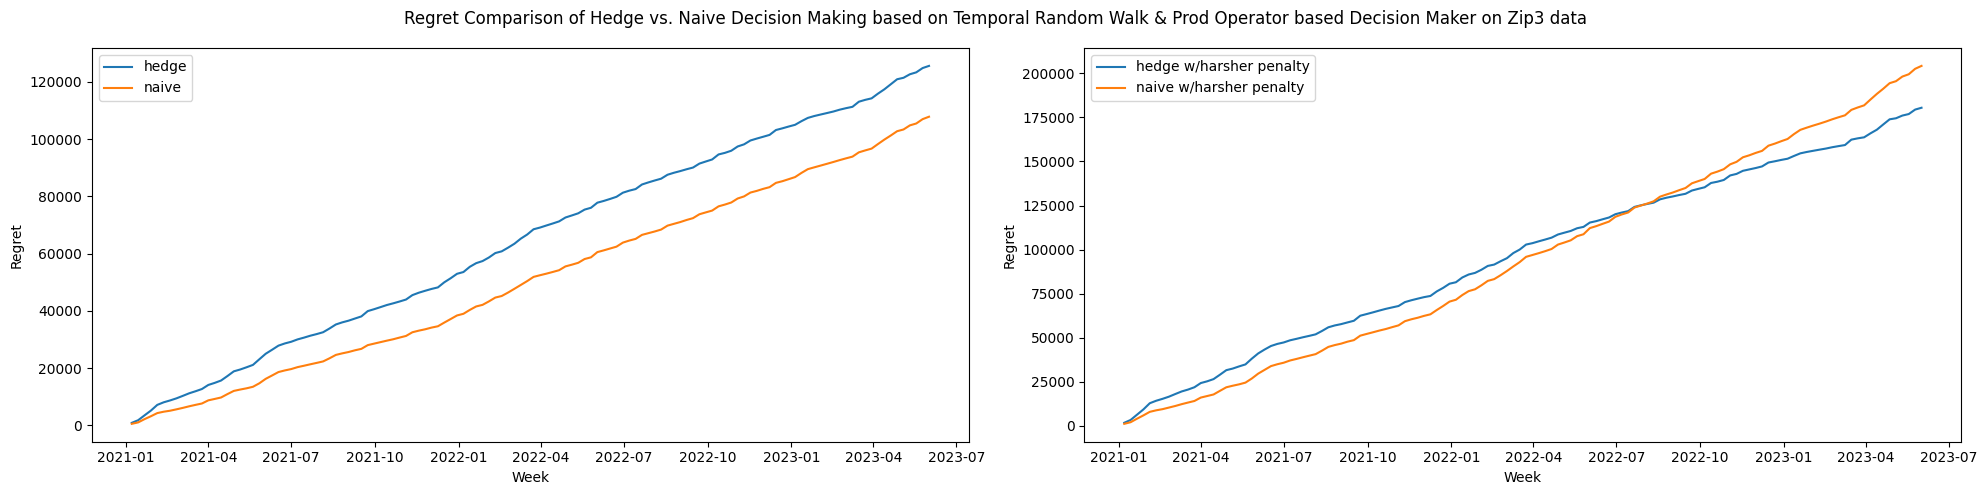

In [67]:
fig, ax = plt.subplots(1,2, figsize= (20, 5))
fig.suptitle("Regret Comparison of Hedge vs. Naive Decision Making based on Temporal Random Walk & Prod Operator based Decision Maker on Zip3 data")
ax[0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.hedge_total_regret['operator_prod'][1:],  label='hedge')
ax[0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.naive_total_regret['operator_prod'][1:],  label='naive')
ax[1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.hedge_total_regret_fp['operator_prod'][1:],  label='hedge w/harsher penalty')
ax[1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.naive_total_regret_fp['operator_prod'][1:],  label='naive w/harsher penalty')
ax[0].legend()
ax[0].set_xlabel("Week")
ax[0].set_ylabel("Regret")
ax[1].legend()
ax[1].set_xlabel("Week")
ax[1].set_ylabel("Regret")
fig.tight_layout()

In [ ]:
# regrets = pd.DataFrame({'hedge': temporal_zip3_dm.hedge_total_regret['operator_prod'][1:], 'naive': temporal_zip3_dm.naive_total_regret['operator_prod'][1:], 'hedge_w_fp': temporal_zip3_dm.hedge_total_regret_fp['operator_prod'][1:], 'naive_w_fp': temporal_zip3_dm.naive_total_regret_fp['operator_prod'][1:]})
# regrets.index = weekly_kma_graphs.keys()
# regrets.to_csv("results/zip3_regrets.csv")

# counts = pd.DataFrame({'hedge_true_positive': temporal_zip3_dm.true_positive_expert['operator_prod'][1:], 'naive_true_positive': temporal_zip3_dm.true_positive_naive['operator_prod'][1:], 'hedge_false_positive': temporal_zip3_dm.false_positive_expert['operator_prod'][1:], 'naive_false_positive': temporal_zip3_dm.false_positive_naive['operator_prod'][1:], 'hedge_false_negative': temporal_zip3_dm.false_negative_expert['operator_prod'][1:], 'naive_false_negative': temporal_zip3_dm.false_negative_naive['operator_prod'][1:]})
# counts['test length'] = temporal_zip3_dm.test_edge_lens
# counts['hedge_fp_true_positive'] = temporal_zip3_dm.true_positive_expert_fp['operator_prod'][1:]
# counts['hedge_fp_false_positive'] = temporal_zip3_dm.false_positive_expert_fp['operator_prod'][1:]
# counts['hedge_fp_false_negative'] = temporal_zip3_dm.false_negative_expert_fp['operator_prod'][1:]
# counts.index = weekly_kma_graphs.keys()
# counts.to_csv("results/zip3_counts.csv")

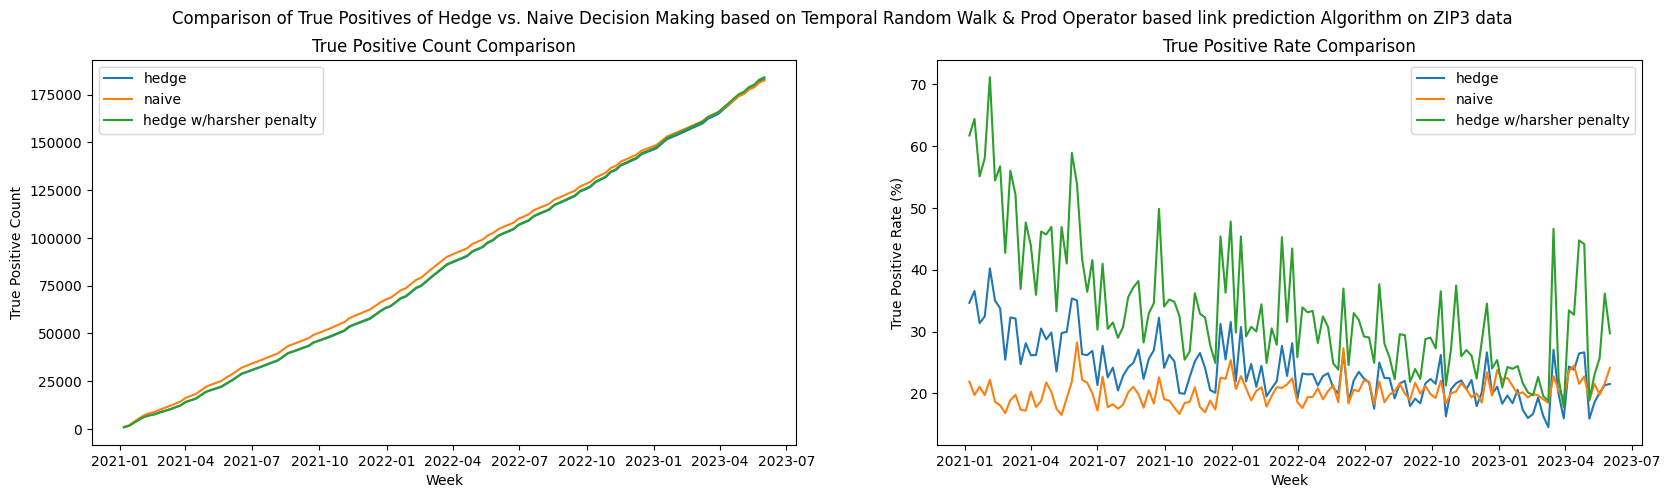

In [68]:
fig, ax = plt.subplots(1,2, figsize= (20, 5))
fig.suptitle("Comparison of True Positives of Hedge vs. Naive Decision Making based on Temporal Random Walk & Prod Operator based link prediction Algorithm on ZIP3 data")
ax[0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.true_positive_expert['operator_prod'][1:],  label='hedge')
ax[0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.true_positive_naive['operator_prod'][1:],  label='naive')
ax[0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.true_positive_expert_fp['operator_prod'][1:],  label='hedge w/harsher penalty')
ax[0].legend()

ax[1].plot(weekly_kma_graphs.keys(), np.diff(temporal_zip3_dm.hedge_total_regret['operator_prod'])/temporal_zip3_dm.test_edge_lens * 100,  label='hedge')
ax[1].plot(weekly_kma_graphs.keys(), np.diff(temporal_zip3_dm.naive_total_regret['operator_prod'])/temporal_zip3_dm.test_edge_lens * 100,  label='naive')
ax[1].plot(weekly_kma_graphs.keys(), np.diff(temporal_zip3_dm.hedge_total_regret_fp['operator_prod'])/temporal_zip3_dm.test_edge_lens * 100,  label='hedge w/harsher penalty')
ax[1].legend()

ax[0].set_xlabel("Week")
ax[0].set_ylabel("True Positive Count")
ax[1].set_xlabel("Week")
ax[1].set_ylabel("True Positive Rate (%)")
ax[0].set_title("True Positive Count Comparison")
ax[1].set_title("True Positive Rate Comparison")
plt.show()

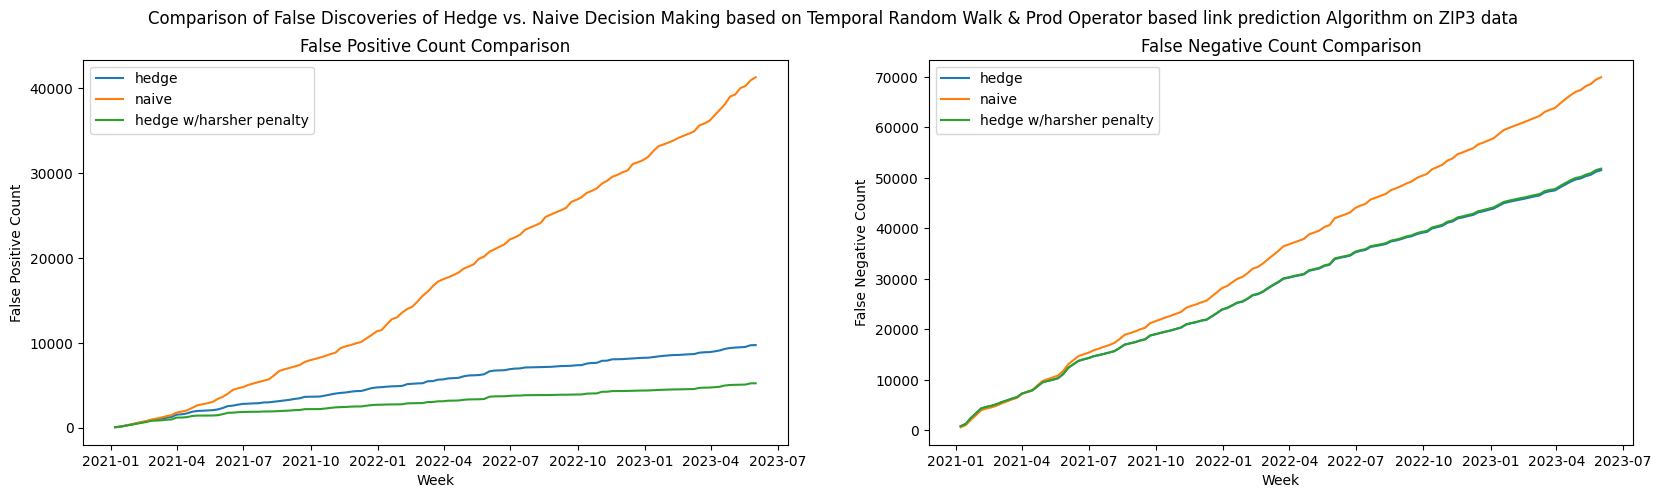

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (20, 5))
fig.suptitle("Comparison of False Discoveries of Hedge vs. Naive Decision Making based on Temporal Random Walk & Prod Operator based link prediction Algorithm on ZIP3 data")
ax[0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_positive_expert['operator_prod'][1:],  label='hedge')
ax[0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_positive_naive['operator_prod'][1:],  label='naive')
ax[0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_positive_expert_fp['operator_prod'][1:],  label='hedge w/harsher penalty')
ax[0].legend()

ax[1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_negative_expert['operator_prod'][1:],   label='hedge')
ax[1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_negative_naive['operator_prod'][1:],   label='naive')
ax[1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_negative_expert_fp['operator_prod'][1:],  label='hedge w/harsher penalty')
ax[1].legend()

ax[0].set_xlabel("Week")
ax[0].set_ylabel("False Positive Count")
ax[1].set_xlabel("Week")
ax[1].set_ylabel("False Negative Count")
ax[0].set_title("False Positive Count Comparison")
ax[1].set_title("False Negative Count Comparison")
plt.show()

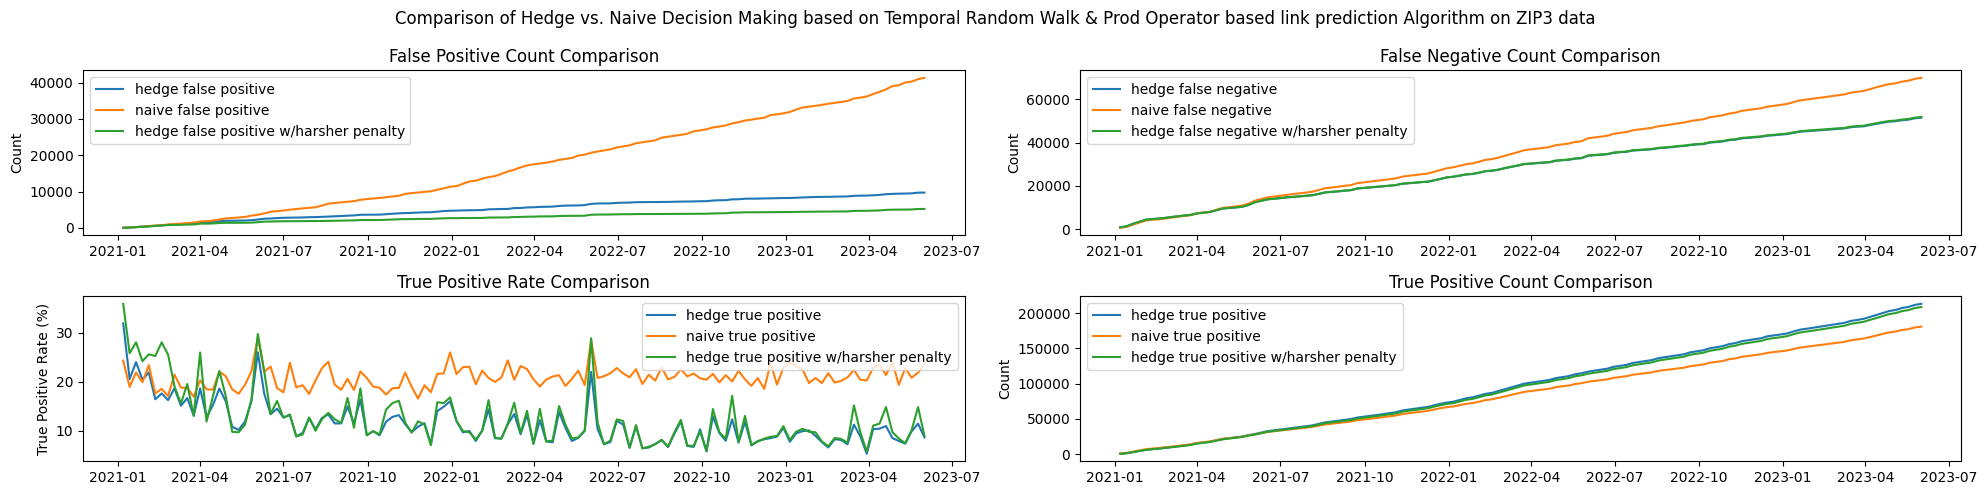

In [ ]:
# graph how many false positives and negatives are made by the expert and naive decision maker
fig, ax = plt.subplots(2,2, figsize= (20, 5))
fig.suptitle("Comparison of Hedge vs. Naive Decision Making based on Temporal Random Walk & Prod Operator based link prediction Algorithm on ZIP3 data")
ax[0][0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_positive_expert['operator_prod'][1:],  label='hedge false positive')
ax[0][1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_negative_expert['operator_prod'][1:],  label='hedge false negative')
ax[1][1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.true_positive_expert['operator_prod'][1:],  label='hedge true positive')
ax[1][0].plot(weekly_kma_graphs.keys(), np.diff(temporal_zip3_dm.hedge_total_regret['operator_prod'])/temporal_zip3_dm.test_edge_lens * 100,  label='hedge true positive')
              
ax[0][0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_positive_naive['operator_prod'][1:],  label='naive false positive')
ax[0][1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_negative_naive['operator_prod'][1:], label='naive false negative')
ax[1][1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.true_positive_naive['operator_prod'][1:],  label='naive true positive')
ax[1][0].plot(weekly_kma_graphs.keys(), np.diff(temporal_zip3_dm.naive_total_regret['operator_prod'])/temporal_zip3_dm.test_edge_lens * 100,  label='naive true positive')

ax[0][0].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_positive_expert_fp['operator_prod'][1:],  label='hedge false positive w/harsher penalty')
ax[0][1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.false_negative_expert_fp['operator_prod'][1:],  label='hedge false negative w/harsher penalty')
ax[1][1].plot(weekly_kma_graphs.keys(), temporal_zip3_dm.true_positive_expert_fp['operator_prod'][1:],  label='hedge true positive w/harsher penalty')
ax[1][0].plot(weekly_kma_graphs.keys(), np.diff(temporal_zip3_dm.hedge_total_regret_fp['operator_prod'])/temporal_zip3_dm.test_edge_lens * 100,  label='hedge true positive w/harsher penalty')

ax[0][0].legend()
ax[0][1].legend()
ax[1][1].legend()
ax[1][0].legend()

ax[0][0].set_ylabel("Count")
ax[0][1].set_ylabel("Count")
ax[1][1].set_ylabel("Count")
ax[1][0].set_ylabel("True Positive Rate (%)")

ax[0][0].set_title("False Positive Count Comparison")
ax[0][1].set_title("False Negative Count Comparison")
ax[1][1].set_title("True Positive Count Comparison")
ax[1][0].set_title("True Positive Rate Comparison")

fig.tight_layout()

In [ ]:
# weight_vectors = pd.DataFrame(temporal_zip3_dm.weight_vectors['operator_prod'])
# weight_vectors.index = [f"expert_{i}" for i in range(1, 11)]
# weight_vectors.columns = [f"route {i}" for i in range(len(weight_vectors.columns))]
# weight_vectors.to_csv("results/zip3_weight_vectors.csv")

# kma level

In [ ]:
temporal_kma_dm = WeeklyDecisionMaker(reward=False)
for graph in tqdm(weekly_kma_graphs.values()):
    temporal_kma_dm.run_expert_simulation(graph, display_progress=True)

In [ ]:
# regrets = pd.DataFrame({'hedge': temporal_kma_dm.hedge_total_regret['operator_prod'][1:], 'naive': temporal_kma_dm.naive_total_regret['operator_prod'][1:], 'hedge_w_fp': temporal_kma_dm.hedge_total_regret_fp['operator_prod'][1:], 'naive_w_fp': temporal_kma_dm.naive_total_regret_fp['operator_prod'][1:]})
# regrets.index = weekly_kma_graphs.keys()
# regrets.to_csv("results/kma_regrets.csv")

# counts = pd.DataFrame({'hedge_true_positive': temporal_kma_dm.true_positive_expert['operator_prod'][1:], 'naive_true_positive': temporal_kma_dm.true_positive_naive['operator_prod'][1:], 'hedge_false_positive': temporal_kma_dm.false_positive_expert['operator_prod'][1:], 'naive_false_positive': temporal_kma_dm.false_positive_naive['operator_prod'][1:], 'hedge_false_negative': temporal_kma_dm.false_negative_expert['operator_prod'][1:], 'naive_false_negative': temporal_kma_dm.false_negative_naive['operator_prod'][1:]})
# counts['test length'] = temporal_kma_dm.test_edge_lens
# counts['hedge_fp_true_positive'] = temporal_kma_dm.true_positive_expert_fp['operator_prod'][1:]
# counts['hedge_fp_false_positive'] = temporal_kma_dm.false_positive_expert_fp['operator_prod'][1:]
# counts['hedge_fp_false_negative'] = temporal_kma_dm.false_negative_expert_fp['operator_prod'][1:]
# counts.index = weekly_kma_graphs.keys()
# counts.to_csv("results/kma_counts.csv")

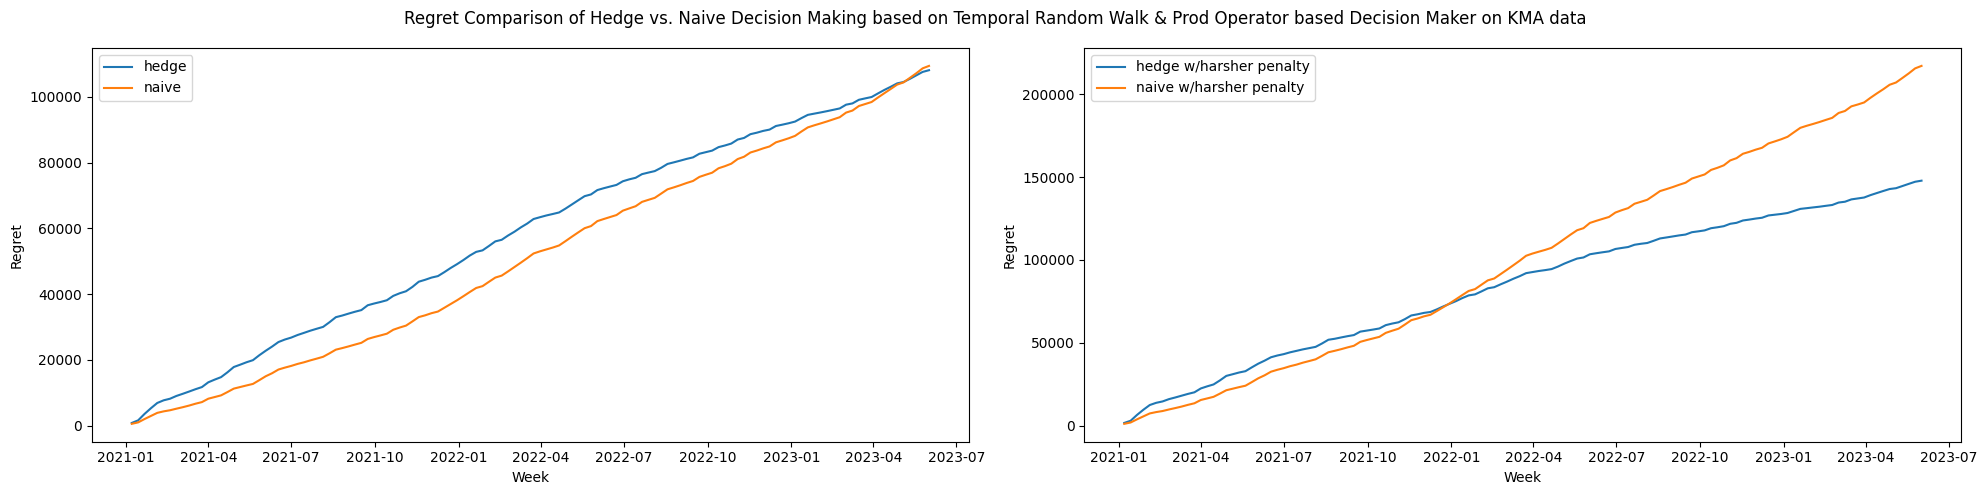

In [59]:
fig, ax = plt.subplots(1,2, figsize= (20, 5))
fig.suptitle("Regret Comparison of Hedge vs. Naive Decision Making based on Temporal Random Walk & Prod Operator based Decision Maker on KMA data")
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.hedge_total_regret['operator_prod'][1:],  label='hedge')
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.naive_total_regret['operator_prod'][1:],  label='naive')
ax[1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.hedge_total_regret_fp['operator_prod'][1:],  label='hedge w/harsher penalty')
ax[1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.naive_total_regret_fp['operator_prod'][1:],  label='naive w/harsher penalty')
ax[0].legend()
ax[0].set_xlabel("Week")
ax[0].set_ylabel("Regret")
ax[1].legend()
ax[1].set_xlabel("Week")
ax[1].set_ylabel("Regret")
fig.tight_layout()

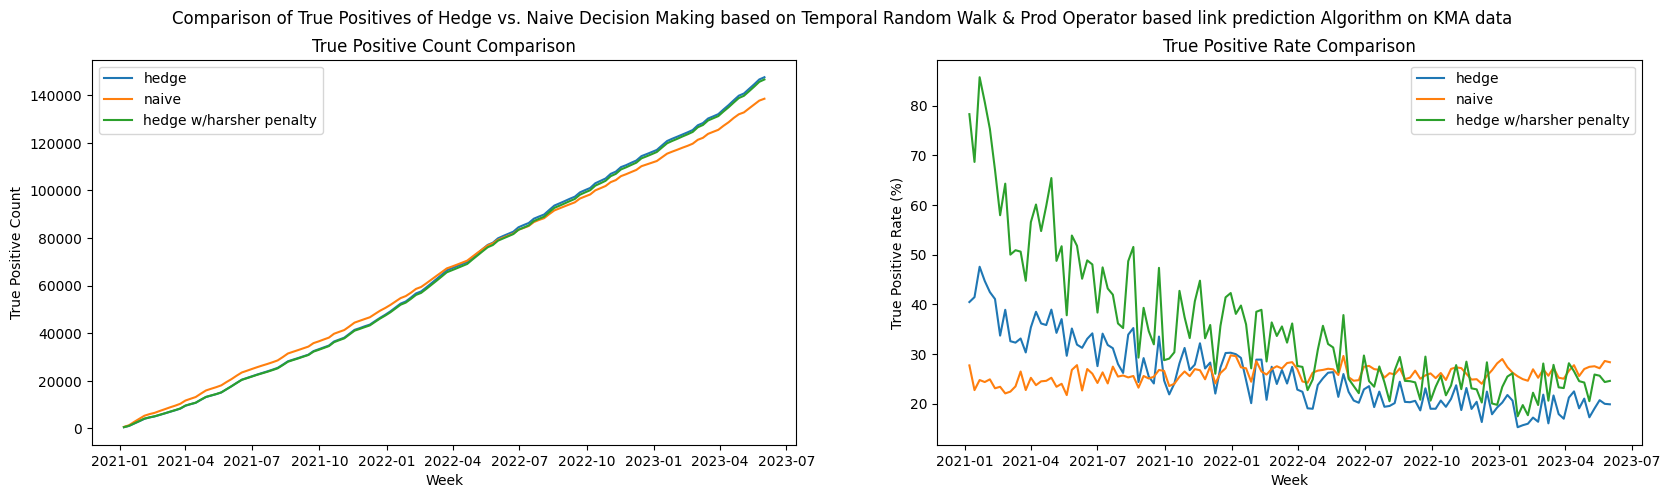

In [60]:
fig, ax = plt.subplots(1,2, figsize= (20, 5))
fig.suptitle("Comparison of True Positives of Hedge vs. Naive Decision Making based on Temporal Random Walk & Prod Operator based link prediction Algorithm on KMA data")
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.true_positive_expert['operator_prod'][1:],  label='hedge')
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.true_positive_naive['operator_prod'][1:],  label='naive')
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.true_positive_expert_fp['operator_prod'][1:],  label='hedge w/harsher penalty')
ax[0].legend()

ax[1].plot(weekly_kma_graphs.keys(), np.diff(temporal_kma_dm.hedge_total_regret['operator_prod'])/temporal_kma_dm.test_edge_lens * 100,  label='hedge')
ax[1].plot(weekly_kma_graphs.keys(), np.diff(temporal_kma_dm.naive_total_regret['operator_prod'])/temporal_kma_dm.test_edge_lens * 100,  label='naive')
ax[1].plot(weekly_kma_graphs.keys(), np.diff(temporal_kma_dm.hedge_total_regret_fp['operator_prod'])/temporal_kma_dm.test_edge_lens * 100,  label='hedge w/harsher penalty')
ax[1].legend()

ax[0].set_xlabel("Week")
ax[0].set_ylabel("True Positive Count")
ax[1].set_xlabel("Week")
ax[1].set_ylabel("True Positive Rate (%)")
ax[0].set_title("True Positive Count Comparison")
ax[1].set_title("True Positive Rate Comparison")
plt.show()

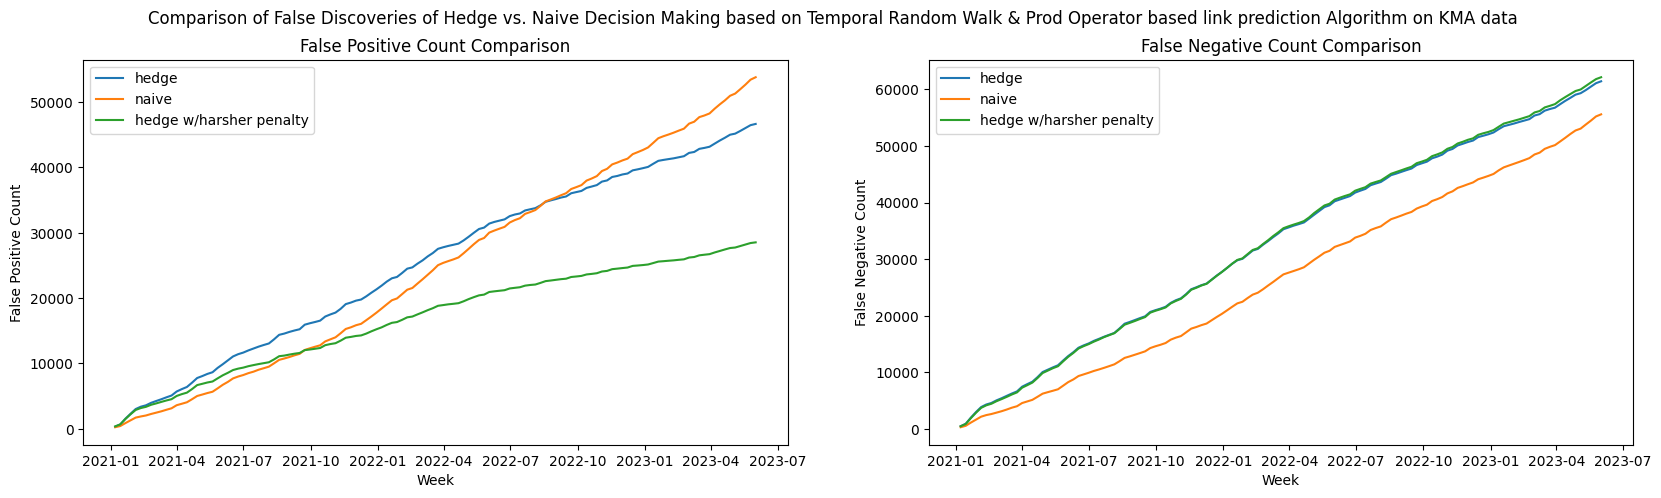

In [61]:
fig, ax = plt.subplots(1,2, figsize= (20, 5))
fig.suptitle("Comparison of False Discoveries of Hedge vs. Naive Decision Making based on Temporal Random Walk & Prod Operator based link prediction Algorithm on KMA data")
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_positive_expert['operator_prod'][1:],  label='hedge')
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_positive_naive['operator_prod'][1:],  label='naive')
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_positive_expert_fp['operator_prod'][1:],  label='hedge w/harsher penalty')
ax[0].legend()

ax[1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_negative_expert['operator_prod'][1:],   label='hedge')
ax[1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_negative_naive['operator_prod'][1:],   label='naive')
ax[1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_negative_expert_fp['operator_prod'][1:],  label='hedge w/harsher penalty')
ax[1].legend()

ax[0].set_xlabel("Week")
ax[0].set_ylabel("False Positive Count")
ax[1].set_xlabel("Week")
ax[1].set_ylabel("False Negative Count")
ax[0].set_title("False Positive Count Comparison")
ax[1].set_title("False Negative Count Comparison")
plt.show()

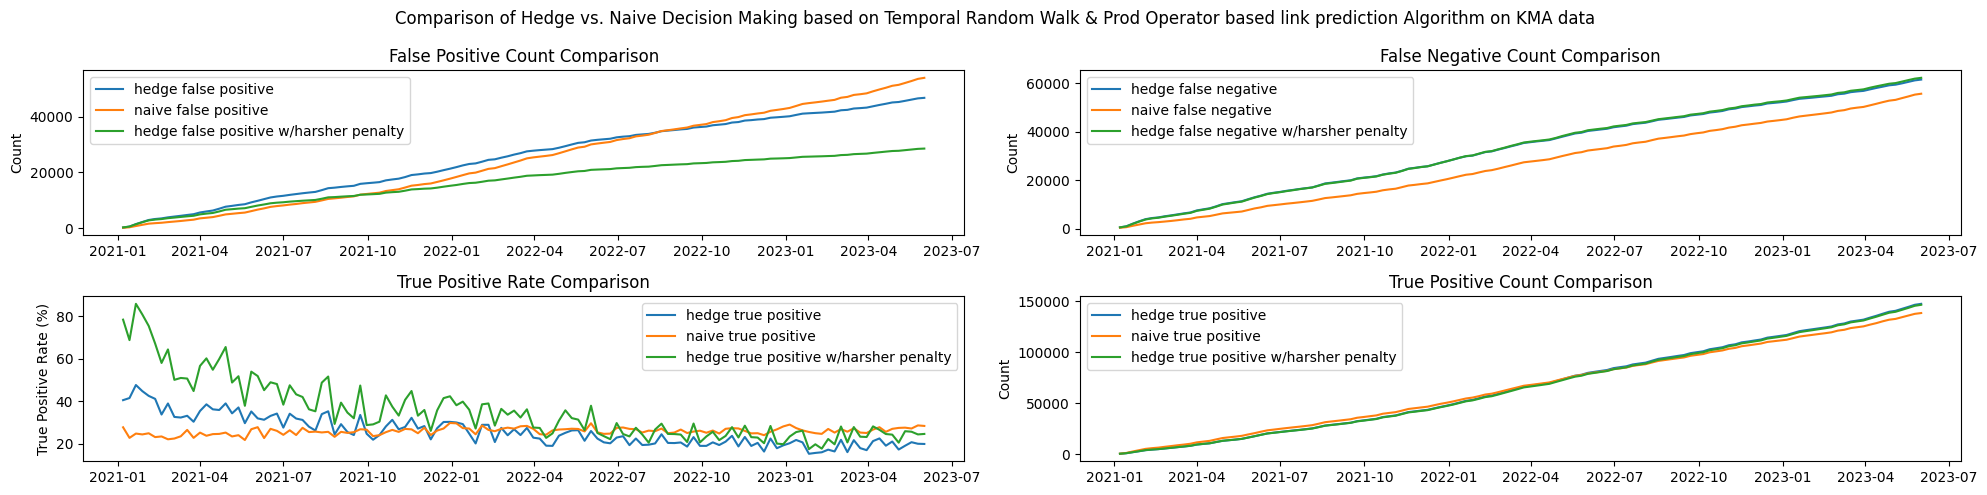

In [62]:
# graph how many false positives and negatives are made by the expert and naive decision maker
fig, ax = plt.subplots(2,2, figsize= (20, 5))
fig.suptitle("Comparison of Hedge vs. Naive Decision Making based on Temporal Random Walk & Prod Operator based link prediction Algorithm on KMA data")
ax[0][0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_positive_expert['operator_prod'][1:],  label='hedge false positive')
ax[0][1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_negative_expert['operator_prod'][1:],  label='hedge false negative')
ax[1][1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.true_positive_expert['operator_prod'][1:],  label='hedge true positive')
ax[1][0].plot(weekly_kma_graphs.keys(), np.diff(temporal_kma_dm.hedge_total_regret['operator_prod'])/temporal_kma_dm.test_edge_lens * 100,  label='hedge true positive')
              
ax[0][0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_positive_naive['operator_prod'][1:],  label='naive false positive')
ax[0][1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_negative_naive['operator_prod'][1:], label='naive false negative')
ax[1][1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.true_positive_naive['operator_prod'][1:],  label='naive true positive')
ax[1][0].plot(weekly_kma_graphs.keys(), np.diff(temporal_kma_dm.naive_total_regret['operator_prod'])/temporal_kma_dm.test_edge_lens * 100,  label='naive true positive')

ax[0][0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_positive_expert_fp['operator_prod'][1:],  label='hedge false positive w/harsher penalty')
ax[0][1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.false_negative_expert_fp['operator_prod'][1:],  label='hedge false negative w/harsher penalty')
ax[1][1].plot(weekly_kma_graphs.keys(), temporal_kma_dm.true_positive_expert_fp['operator_prod'][1:],  label='hedge true positive w/harsher penalty')
ax[1][0].plot(weekly_kma_graphs.keys(), np.diff(temporal_kma_dm.hedge_total_regret_fp['operator_prod'])/temporal_kma_dm.test_edge_lens * 100,  label='hedge true positive w/harsher penalty')

ax[0][0].legend()
ax[0][1].legend()
ax[1][1].legend()
ax[1][0].legend()

ax[0][0].set_ylabel("Count")
ax[0][1].set_ylabel("Count")
ax[1][1].set_ylabel("Count")
ax[1][0].set_ylabel("True Positive Rate (%)")

ax[0][0].set_title("False Positive Count Comparison")
ax[0][1].set_title("False Negative Count Comparison")
ax[1][1].set_title("True Positive Count Comparison")
ax[1][0].set_title("True Positive Rate Comparison")

fig.tight_layout()

In [ ]:
# weight_vectors = pd.DataFrame(temporal_kma_dm.weight_vectors['operator_prod'].values()).T
# weight_vectors.index = [f"expert_{i}" for i in range(1, 11)]
# weight_vectors.columns = [f"route {i}" for i in range(len(weight_vectors.columns))]
# weight_vectors.to_csv("results/kma_weight_vectors.csv")

In [ ]:
# temporal_kma_reward_dm = WeeklyDecisionMaker(reward=True)
# for graph in tqdm(weekly_kma_graphs.values()):
#     temporal_kma_reward_dm.run_expert_simulation(graph, display_progress=True)

# fig, ax = plt.subplots(1,1, figsize= (10, 5))
# fig.suptitle("Regret Comparison of Temporal Random Walk based Decision Maker on KMA data w/Reward")
# ax.plot(weekly_kma_graphs.keys(), temporal_kma_reward_dm.hedge_total_regret['operator_sub'][1:],  label='hedge')
# ax.plot(weekly_kma_graphs.keys(), temporal_kma_reward_dm.naive_total_regret['operator_sub'][1:],  label='naive')
# ax.legend()
# ax.set_xlabel("Week")
# ax.set_ylabel("Regret")
# fig.tight_layout()

In [ ]:
# static_kma_dm = WeeklyDecisionMaker(reward=False)
# for graph in tqdm(weekly_kma_graphs.values()):
#     static_kma_dm.run_expert_simulation(graph, temporal=False, display_progress=True)

# fig, ax = plt.subplots(1,2, figsize= (20, 3))
# fig.suptitle("Regret Comparison of Temporal vs Static Decision Maker on KMA data")
# ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.hedge_total_regret['operator_sub'][1:], label='hedge')
# ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_dm.naive_total_regret['operator_sub'][1:], label='naive')
# # ax[0].set_ylim(0, 100000)
# ax[0].legend()
# ax[0].set_title("Temporal Zip3 Decision Maker")
# ax[1].plot(weekly_kma_graphs.keys(), static_kma_dm.hedge_total_regret['operator_sub'][1:], label='hedge')
# ax[1].plot(weekly_kma_graphs.keys(), static_kma_dm.naive_total_regret['operator_sub'][1:], label='naive')
# # ax[1].set_ylim(-700000, 100000)
# ax[1].legend()
# ax[1].set_title("Static Zip3 Decision Maker")
# plt.show()

# Reward

In [ ]:
static_kma_reward_dm = WeeklyDecisionMaker(reward=True)
for graph in tqdm(weekly_kma_graphs.values()):
    static_kma_reward_dm.run_expert_simulation(graph, temporal=False, display_progress=True)

fig, ax = plt.subplots(1,2, figsize= (20, 3))
fig.suptitle("Regret Comparison of Temporal vs Static Decision Maker on KMA data w/Reward")
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_reward_dm.hedge_total_regret['operator_sub'][1:], label='hedge')
ax[0].plot(weekly_kma_graphs.keys(), temporal_kma_reward_dm.naive_total_regret['operator_sub'][1:], label='naive')
# ax[0].set_ylim(0, 100000)
ax[0].legend()
ax[0].set_title("Temporal Zip3 Decision Maker")
ax[1].plot(weekly_kma_graphs.keys(), static_kma_reward_dm.hedge_total_regret['operator_sub'][1:], label='hedge')
ax[1].plot(weekly_kma_graphs.keys(), static_kma_reward_dm.naive_total_regret['operator_sub'][1:], label='naive')
# ax[1].set_ylim(-700000, 100000)
ax[1].legend()
ax[1].set_title("Static Zip3 Decision Maker")
plt.show()

In [ ]:
results = pd.read_csv("results/temporal_zip3_dm_result.csv")
hedge_results, naive_results = list(results['hedge']), list(results['naive'])

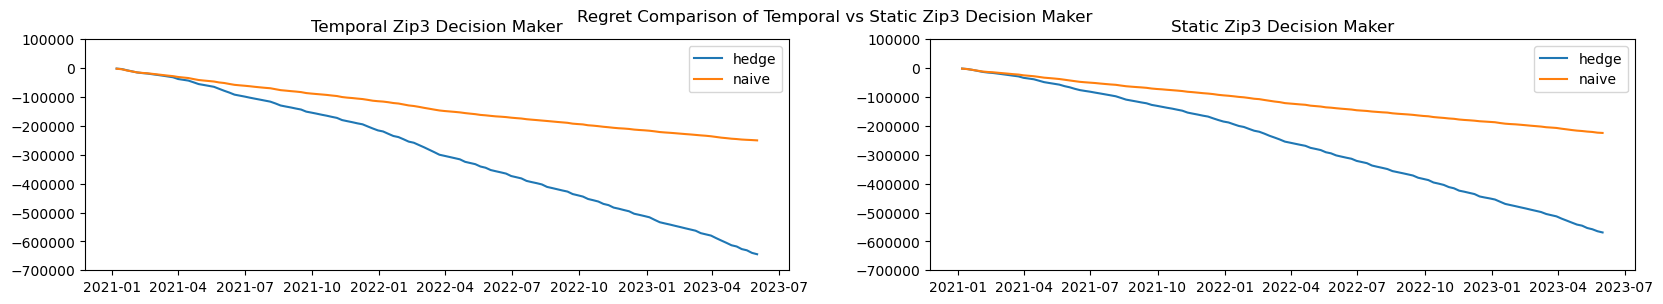

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (20, 3))
fig.suptitle("Regret Comparison of Temporal vs Static Zip3 Decision Maker")
ax[0].plot(weekly_zip3_graphs.keys(), hedge_results[1:], label='hedge')
ax[0].plot(weekly_zip3_graphs.keys(), naive_results[1:], label='naive')
ax[0].set_ylim(-700000, 100000)
ax[0].legend()
ax[0].set_title("Temporal Zip3 Decision Maker")
ax[1].plot(weekly_zip3_graphs.keys(), static_zip3_dm.hedge_total_regret[1:], label='hedge')
ax[1].plot(weekly_zip3_graphs.keys(), static_zip3_dm.naive_total_regret[1:], label='naive')
ax[1].set_ylim(-700000, 100000)
ax[1].legend()
ax[1].set_title("Static Zip3 Decision Maker")
plt.show()

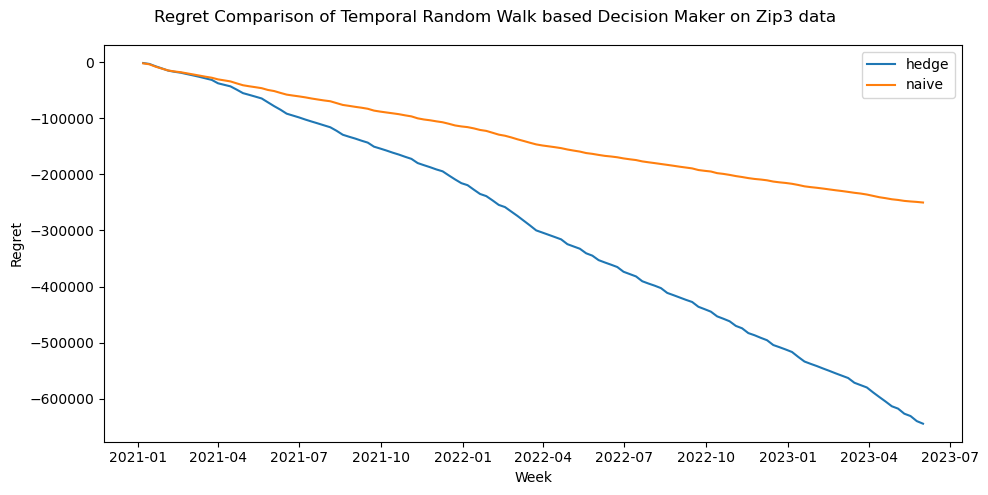

In [ ]:
fig, ax = plt.subplots(1,1, figsize= (10, 5))
fig.suptitle("Regret Comparison of Temporal Random Walk based Decision Maker on Zip3 data")
ax.plot(weekly_zip3_graphs.keys(), hedge_results[1:], label='hedge')
ax.plot(weekly_zip3_graphs.keys(), naive_results[1:], label='naive')
ax.legend()
ax.set_xlabel("Week")
ax.set_ylabel("Regret")
fig.tight_layout()

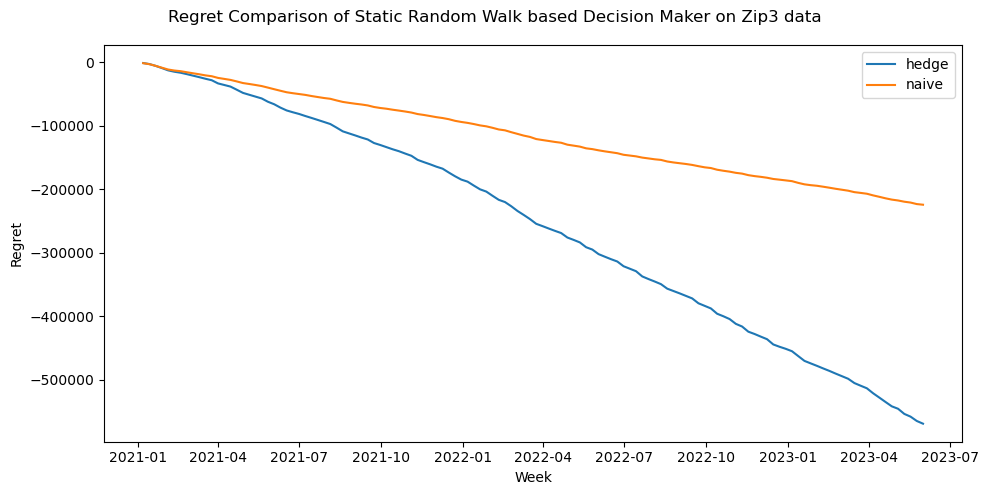

In [ ]:
temporal_kma_dm = WeeklyDecisionMaker(reward=False)
for graph in tqdm(weekly_kma_graphs.values()):
    temporal_kma_dm.run_expert_simulation(graph, display_progress=False)

fig, ax = plt.subplots(1,1, figsize= (10, 5))
fig.suptitle("Regret Comparison of Temporal Random Walk based Decision Maker on KMA data")
ax.plot(weekly_zip3_graphs.keys(), temporal_kma_dm.hedge_total_regret[1:], label='hedge')
ax.plot(weekly_zip3_graphs.keys(), temporal_kma_dm.naive_total_regret[1:], label='naive')
ax.legend()
ax.set_xlabel("Week")
ax.set_ylabel("Regret")
fig.tight_layout()

In [ ]:
static_kma_dm = WeeklyDecisionMaker(reward=False)
for graph in tqdm(weekly_kma_graphs.values()):
    static_kma_dm.run_expert_simulation(graph, temporal=False, display_progress=False)

fig, ax = plt.subplots(1,1, figsize= (10, 5))
fig.suptitle("Regret Comparison of Static Random Walk based Decision Maker on KMA data")
ax.plot(weekly_zip3_graphs.keys(), static_kma_dm.hedge_total_regret[1:], label='hedge')
ax.plot(weekly_zip3_graphs.keys(), static_kma_dm.naive_total_regret[1:], label='naive')
ax.legend()
ax.set_xlabel("Week")
ax.set_ylabel("Regret")
fig.tight_layout()

# single route 

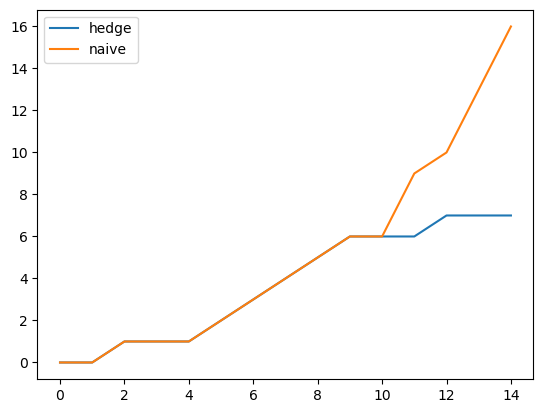

In [ ]:
# show only increase in lp.target_regrets[('13', '60')]
increase_hedge_regret = []
test = lp.target_regrets[]
for i, x in enumerate(test):
    if i == 0: continue 
    if test[i-1] < x: 
        increase_hedge_regret.append(x-test[i-1])
    else: increase_hedge_regret.append(0)

increase_naive_regret = []
test = lp.naive_target_regrets[]
for i, x in enumerate(test):
    if i == 0: continue 
    if test[i-1] < x: 
        increase_naive_regret.append(x-test[i-1])
    else: increase_naive_regret.append(0)

plt.plot(np.arange(len(weight2) -1 ), np.cumsum(increase_hedge_regret), label='hedge')
plt.plot(np.arange(len(weight2) -1 ), np.cumsum(increase_naive_regret), label='naive')
plt.legend()

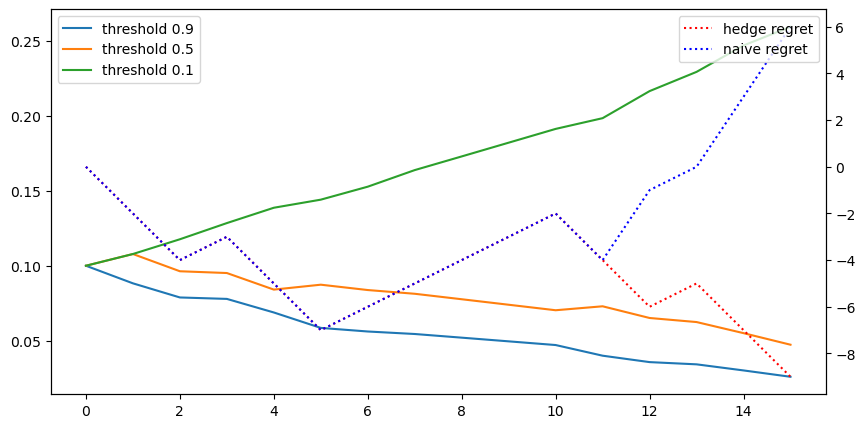

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# weight2 = np.array(lp.past_weight_vectors[]) #deleted for anonymity
ax.plot(np.arange(len(weight2)), weight2[:, 9], label=f'threshold 0.9')
ax.plot(np.arange(len(weight2)), weight2[:, 5], label=f'threshold 0.5')
ax.plot(np.arange(len(weight2)), weight2[:, 0], label=f'threshold 0.1')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(np.arange(len(weight2)), lp.target_regrets[('13', '60')], label='hedge regret', color='r', linestyle=':')
ax2.plot(np.arange(len(weight2)), lp.naive_target_regrets[('13', '60')], label='naive regret', color='b', linestyle=':')
ax2.legend(loc='upper right')